In [47]:
import pickle
from matplotlib import pyplot as plt
import os
import numpy as np
import glob

In [103]:
files = None
if os.path.exists("models"):
    for file in os.listdir("models"):
        if file.endswith(".pkl"):
            files = glob.glob("models/*fullresults*.pkl")
    if files == [] or None:
        print("No result files found in 'models'")
        print("Make sure to run the circuit and solver scripts first,\n" \
        "and set '--savedata' flag in the solver script.")
else:
    print("Could not find directory 'models'")
    print("Make sure to run the circuit and solver scripts first.")
    exit(1)

In [82]:
def get_backend(filename):
    # Define the start and end patterns
    start_pattern = 'backend-'
    end_pattern = '_shots'
    
    # Find the starting index
    start_index = filename.find(start_pattern)
    if start_index == -1:
        return None  # Return None if 'backend-' is not found

    # Adjust start_index to point to the start of the desired string (after 'backend-')
    start_index += len(start_pattern)

    # Find the ending index
    end_index = filename.find(end_pattern, start_index)
    if end_index == -1:
        return None  # Return None if '.pkl' is not found

    # Extract and return the desired string
    return filename[start_index:end_index]

In [88]:
print(set([get_backend(file) for file in files]))

{'garnet:mock'}


In [106]:
backends = set([get_backend(file) for file in files])
backend_results = {}
for backend in backends:
    fidelities = {}
    for file in files:
        if backend != get_backend(file):
            continue
        with open(file, "rb") as f:
            results = pickle.load(f)
            fidelities[results['shots']] = results['fidelity']
    backend_results[backend] = fidelities
backend_results

{'garnet:mock': {10000: 0.8999999999999999,
  20000: 0.8999999999999999,
  1000: 0.09999999999999996,
  100: 0.8999999999999999},
 'garnet': {10000: 0.7923994256488703, 1000: 0.8562285116243978}}

In [98]:
sorted(backend_results['garnet:mock'].items())

[(100, 0.8999999999999999),
 (1000, 0.09999999999999996),
 (10000, 0.8999999999999999),
 (20000, 0.8999999999999999)]

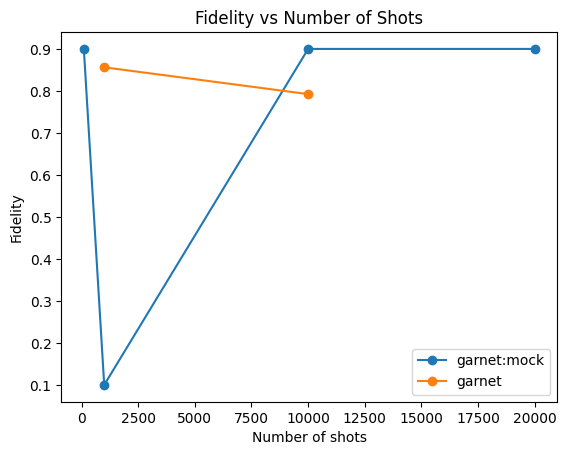

In [108]:
for backend, fidelities in backend_results.items():
    sorted_fidelities = dict(sorted(fidelities.items()))
    plt.plot(list(sorted_fidelities.keys()), list(sorted_fidelities.values()), marker='o', label=backend)
    plt.xlabel("Number of shots")
    plt.ylabel("Fidelity")
    plt.title("Fidelity vs Number of Shots")
    plt.legend()
plt.savefig("fidelity_vs_shots.png", format='png')

In [1]:
import numpy as np
from qiskit.quantum_info import state_fidelity # Assuming this is used elsewhere or intended

def get_ancilla_probabilities(counts: dict, num_solution_qubits: int) -> tuple[list, int, np.ndarray, np.ndarray]:
    """
    Filters measurement counts for states where the ancilla qubit is '1',
    calculates the total counts for the solution subspace, and derives
    probability vectors.

    Assumes qubit ordering: |Ancilla> |Ancillary/Work> |Solution>
    Assumes the 'relevant' states are those where Ancilla='1' and Work='00...0'.

    Args:
        counts: Dictionary of measurement outcomes (bitstrings) and their counts.
        num_solution_qubits: The number of qubits representing the solution vector (nq).

    Returns:
        A tuple containing:
        - counts_ancilla_sorted: List of (bitstring, count) tuples where ancilla is '1',
                                 sorted by the solution qubit values.
        - counts_total: Sum of counts for the relevant solution states (ancilla=1, work=0).
        - probs_vector: Numpy array of probabilities for each solution basis state.
        - state_vector_estimate: Numpy array proportional to the estimated solution
                                 state vector (sqrt of probabilities).
    """
    if not counts:
        # Handle empty input counts
        num_states = 2**num_solution_qubits
        return [], 0, np.zeros(num_states), np.zeros(num_states)

    # Determine the expected prefix for relevant states (Ancilla=1, Work=0...0)
    total_qubits = len(next(iter(counts)))
    num_work_qubits = total_qubits - num_solution_qubits - 1
    if num_work_qubits < 0:
        raise ValueError("Inconsistent qubit counts: total_qubits < num_solution_qubits + 1")
    bits_prefix = "1" + "0" * num_work_qubits

    # --- Refactored Zero-Padding ---
    # Ensure all potential solution states (with the correct prefix) exist in counts
    num_states = 2**num_solution_qubits
    for i in range(num_states):
        # Format number as binary string, padded with leading zeros to num_solution_qubits
        solution_bits = format(i, f'0{num_solution_qubits}b')
        full_key = bits_prefix + solution_bits
        if full_key not in counts:
            counts[full_key] = 0 # Add missing states with 0 count

    # --- Refactored Filtering & Sorting ---
    counts_ancilla_filtered = []
    for key, value in counts.items():
        # Filter for states starting with the specific prefix we care about
        if key.startswith(bits_prefix):
             # Store only the solution part of the key for sorting, and the count
            counts_ancilla_filtered.append((key, value))

    # Sort based on the solution part of the key (last num_solution_qubits bits)
    # This ensures states are ordered correctly from |0...0> to |1...1>
    counts_ancilla_sorted = sorted(counts_ancilla_filtered, key=lambda item: item[0][-num_solution_qubits:])

    # --- Refactored Calculation ---
    counts_total = 0
    # Sum counts only for the expected number of solution states
    # This relies on the zero-padding and sorting being correct.
    for i in range(min(num_states, len(counts_ancilla_sorted))):
         counts_total += counts_ancilla_sorted[i][1]

    probs_vector_list = []
    state_vector_list = []

    if counts_total == 0:
        # Handle division by zero case
        probs_vector = np.zeros(num_states)
        state_vector_estimate = np.zeros(num_states)
    else:
        for i in range(min(num_states, len(counts_ancilla_sorted))):
            count_val = counts_ancilla_sorted[i][1]
            prob = count_val / counts_total
            probs_vector_list.append(prob)
            state_vector_list.append(np.sqrt(prob))

        # Ensure vectors have the correct length (padding if sort/filter missed something unexpected)
        while len(probs_vector_list) < num_states:
            probs_vector_list.append(0.0)
            state_vector_list.append(0.0)

        probs_vector = np.array(probs_vector_list)
        state_vector_estimate = np.array(state_vector_list)

    # Return the sorted list, total, and the calculated vectors
    return counts_ancilla_sorted, counts_total, probs_vector, state_vector_estimate

# Example usage (replace with actual counts and nq)
# counts_example = {'1000': 50, '1010': 150, '0000': 800}
# nq_example = 2
# result = get_ancilla_probabilities(counts_example, nq_example)
# print(result)


In [30]:
def get_ancillaqubit(counts, nq):
    """
    NOTE: only count measurements when ancilla qubit (leftmost) is 1
    Input:
        counts   counts from the simulator
        nq       number of qubits used to represent the system or solution vector
    Output:
        counts_ancill     accounts of the measurements where ancilla qubit = 1
        other metrics for combination of nq qubits = 1
    """
    if not counts:
        # Handle empty input counts
        num_states = 2**nq
        return [], 0, np.zeros(num_states), np.zeros(num_states)

    # Determine the expected prefix for relevant states (Ancilla=1, Work=0...0)
    total_qubits = len(next(iter(counts)))
    num_work_qubits = total_qubits - nq - 1
    if num_work_qubits < 0:
        raise ValueError("Inconsistent qubit counts: total_qubits < num_solution_qubits + 1")
    bits_prefix = "1" + "0" * num_work_qubits

    def _print_the_array(arr, n):
        cache = ""
        for i in range(0, n):
            cache += str(arr[i])
        if bits_prefix + cache not in counts:
            counts[bits_prefix + cache] = 0

    # Function to generate all binary strings
    def _generate_all_binary_strings(n, arr, i):
        if i == n:
            _print_the_array(arr, n)
            return
        # First assign "0" at ith position
        # and try for all other permutations
        # for remaining positions
        arr[i] = 0
        _generate_all_binary_strings(n, arr, i + 1)
        # And then assign "1" at ith position
        # and try for all other permutations
        # for remaining positions
        arr[i] = 1
        _generate_all_binary_strings(n, arr, i + 1)

    arr = [None] * len(next(iter(counts)))

    # Print all binary strings
    _generate_all_binary_strings(nq, arr, 0)

    counts_list = list(counts.items())
    counts_ancilla = []
    ancilla_states = []
    # check the left most qubit
    for i in range(len(counts_list)):
        if counts_list[i][0][0] == "1":  # extract all ancilla qubits=1
            counts_ancilla += (counts_list[i],)
            ancilla_states += (counts_list[i][0],)
    # sort based on right most qubits. Find the argsort and manually rearrange the counts list.
    ancilla_states_sortedID = np.argsort(ancilla_states)
    counts_ancilla_sorted = []
    for i in range(len(counts_ancilla)):
        counts_ancilla_sorted += (counts_ancilla[ancilla_states_sortedID[i]],)
    counts_ancilla = counts_ancilla_sorted.copy()

    # At this point, all the states are sorted such that ancilla=1 and the
    # combination of nb qubits is 0 or 1
    # So, we take the first 2**nb states (OR size of the system)
    num_state = 2**nq
    # print(f'The number of counts of ancilla bits: {len(counts_ancilla)},
    # N.O num_state: {num_state}')
    # re-compute counts_total
    counts_total = 0
    for i in range(num_state):
        counts_total += counts_ancilla[i][1]
    # compute solution vectors
    probs_vector = []
    counts_vector = []
    for i in range(num_state):
        probs_vector += (counts_ancilla[i][1] / (1.0 * counts_total),)
        counts_vector += (np.sqrt(counts_ancilla[i][1] / (1.0 * counts_total)),)
    return counts_ancilla, counts_total, np.array(probs_vector), np.array(counts_vector)

get_ancillaqubit(counts2, 2)

ZeroDivisionError: float division by zero

In [32]:
counts = {'00000': 5049, '10010': 5048, '11111': 4882, '01101': 5021}
counts2 = {'1000101': 2494, '0110000': 2500, '1001111': 2503, '0111010': 2516, '1111111': 2475, '0001010': 2463, '1110101': 2514, '0000000': 2535}
get_ancilla_probabilities(counts2, 2)


([('1000000', 0), ('1000001', 0), ('1000010', 0), ('1000011', 0)],
 0,
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]))

In [45]:
# get_ancillaqubit(counts, 1)
nq = 1
"""
NOTE: only count measurements when ancilla qubit (leftmost) is 1
Input:
    counts   counts from the simulator
    nq       number of qubits used to represent the system or solution vector
Output:
    counts_ancill     accounts of the measurements where ancilla qubit = 1
    other metrics for combination of nq qubits = 1
"""
# if not counts:
#     # Handle empty input counts
#     num_states = 2**nq
#     return [], 0, np.zeros(num_states), np.zeros(num_states)

# Determine the expected prefix for relevant states (Ancilla=1, Work=0...0)
# add 0-count measurements results
total_qubits = len(next(iter(counts)))
num_work_qubits = total_qubits - nq - 1
if num_work_qubits < 0:
    raise ValueError("Inconsistent qubit counts: total_qubits < num_solution_qubits + 1")
bits_prefix = "1" + "0" * num_work_qubits

def _print_the_array(arr, n):
    cache = ""
    for i in range(0, n):
        cache += str(arr[i])
    if bits_prefix + cache not in counts:
        counts[bits_prefix + cache] = 0

# Function to generate all binary strings
def _generate_all_binary_strings(n, arr, i):
    if i == n:
        _print_the_array(arr, n)
        return
    # First assign "0" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 0
    _generate_all_binary_strings(n, arr, i + 1)
    # And then assign "1" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 1
    _generate_all_binary_strings(n, arr, i + 1)

arr = [None] * len(next(iter(counts)))

# Print all binary strings
_generate_all_binary_strings(nq, arr, 0)

counts_list = list(counts.items())
counts_ancilla = []
ancilla_states = []
# check the left most qubit
for i in range(len(counts_list)):
    if counts_list[i][0][0] == "1":  # extract all ancilla qubits=1
        counts_ancilla += (counts_list[i],)
        ancilla_states += (counts_list[i][0],)
# sort based on right most qubits. Find the argsort and manually rearrange the counts list.
ancilla_states_sortedID = np.argsort(ancilla_states)
counts_ancilla_sorted = []
for i in range(len(counts_ancilla)):
    counts_ancilla_sorted += (counts_ancilla[ancilla_states_sortedID[i]],)
counts_ancilla = counts_ancilla_sorted.copy()

# At this point, all the states are sorted such that ancilla=1 and the
# combination of nb qubits is 0 or 1
# So, we take the first 2**nb states (OR size of the system)
num_state = 2**nq
# print(f'The number of counts of ancilla bits: {len(counts_ancilla)},
# N.O num_state: {num_state}')
# re-compute counts_total
counts_total = 0
for i in range(num_state):
    counts_total += counts_ancilla[i][1]
# compute solution vectors
probs_vector = []
counts_vector = []
tick = 1
for i in range(num_state):
    try:
        probs_vector += (counts_ancilla[i][1] / (1.0 * counts_total),)
        counts_vector += (np.sqrt(counts_ancilla[i][1] / (1.0 * counts_total)),)
    except ZeroDivisionError:
        print(f"\
              *****************WARNING************************\n\
                ZeroDivisionError: counts_ancilla[{i}] = {counts_ancilla[i]}\n\
                Could be a result of bad simulator results. Generating fake probs_vector\n\
                and counts_vector...")
        if tick%2 == 0:
            probs_vector += (1.0,)
            counts_vector += (1.0,)
        else:
            probs_vector += (0.0,)
            counts_vector += (0.0,)
        tick += 1

counts_ancilla, counts_total, np.array(probs_vector), np.array(counts_vector)

              *****************WARNING************************
                ZeroDivisionError: counts_ancilla[0] = ('10000', 0)
                Could be a result of bad simulator results. Generating fake probs_vector
                and counts_vector...
              *****************WARNING************************
                ZeroDivisionError: counts_ancilla[1] = ('10001', 0)
                Could be a result of bad simulator results. Generating fake probs_vector
                and counts_vector...


([('10000', 0),
  ('10001', 0),
  ('10010', 5048),
  ('10011', 0),
  ('10100', 0),
  ('10101', 0),
  ('10110', 0),
  ('10111', 0),
  ('11000', 0),
  ('11001', 0),
  ('11010', 0),
  ('11011', 0),
  ('11100', 0),
  ('11101', 0),
  ('11110', 0),
  ('11111', 4882)],
 0,
 array([0., 1.]),
 array([0., 1.]))

In [44]:
1%2

1